# 15. 문자를 읽을 수 있는 딥러닝

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

- 기획한 서비스가 OCR 적용 가능한 서비스이며, OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

- 앞서 기획한 서비스에서 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.


In [3]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

In [4]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test/'


images = glob(work_dir+'*.png')
images.sort()
images

['/aiffel/aiffel/ocr_python/test/17.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.22.32.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.23.27.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.24.05.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.28.05.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.28.15.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.29.05.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.30.07.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.30.23.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.30.36.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.30.46.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.30.56.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.31.13.png',
 '/aiffel/aiffel/ocr_python/test/스크린샷 2023-01-04 오후 4.31.29.png']

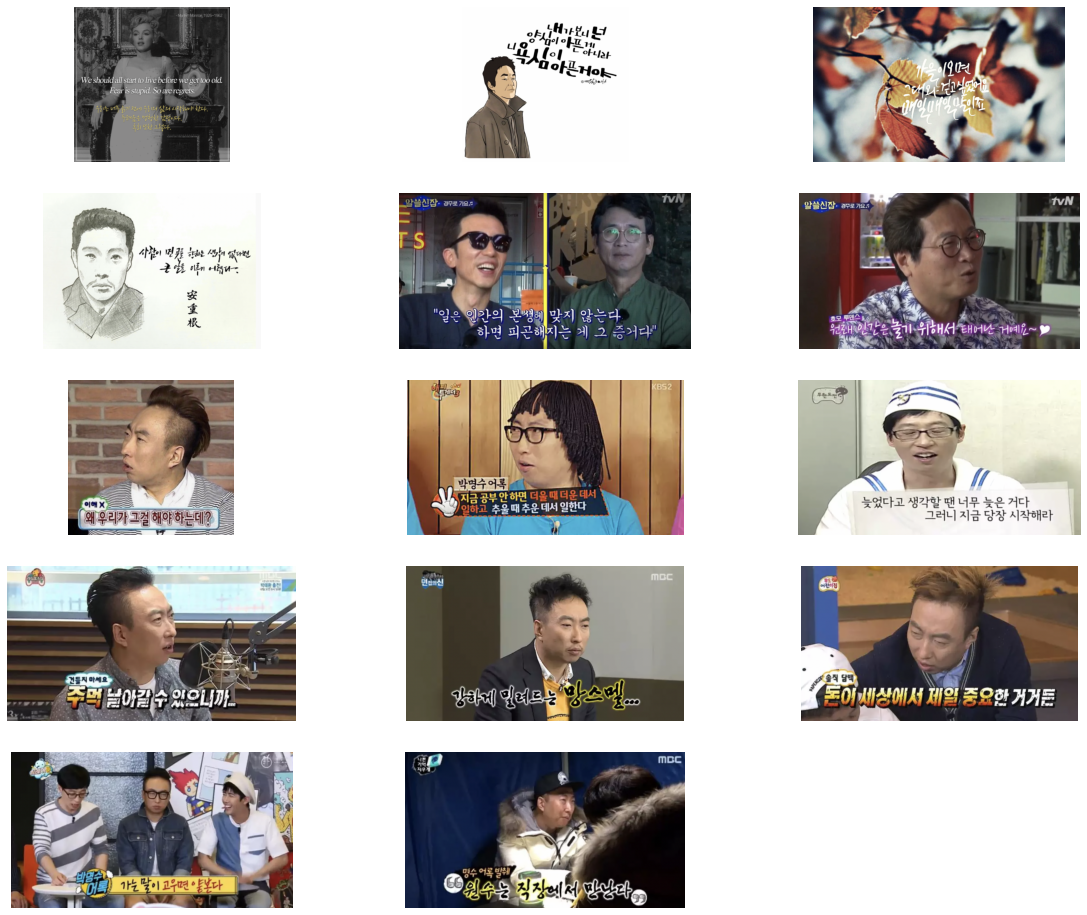

In [5]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(images):
    plt.subplot(6, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

# keras-ocr

In [6]:
pipeline = keras_ocr.pipeline.Pipeline()


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
images_keras_ocr = [ keras_ocr.tools.read(im) for im in images]
prediction_groups = [pipeline.recognize([im]) for im in images]

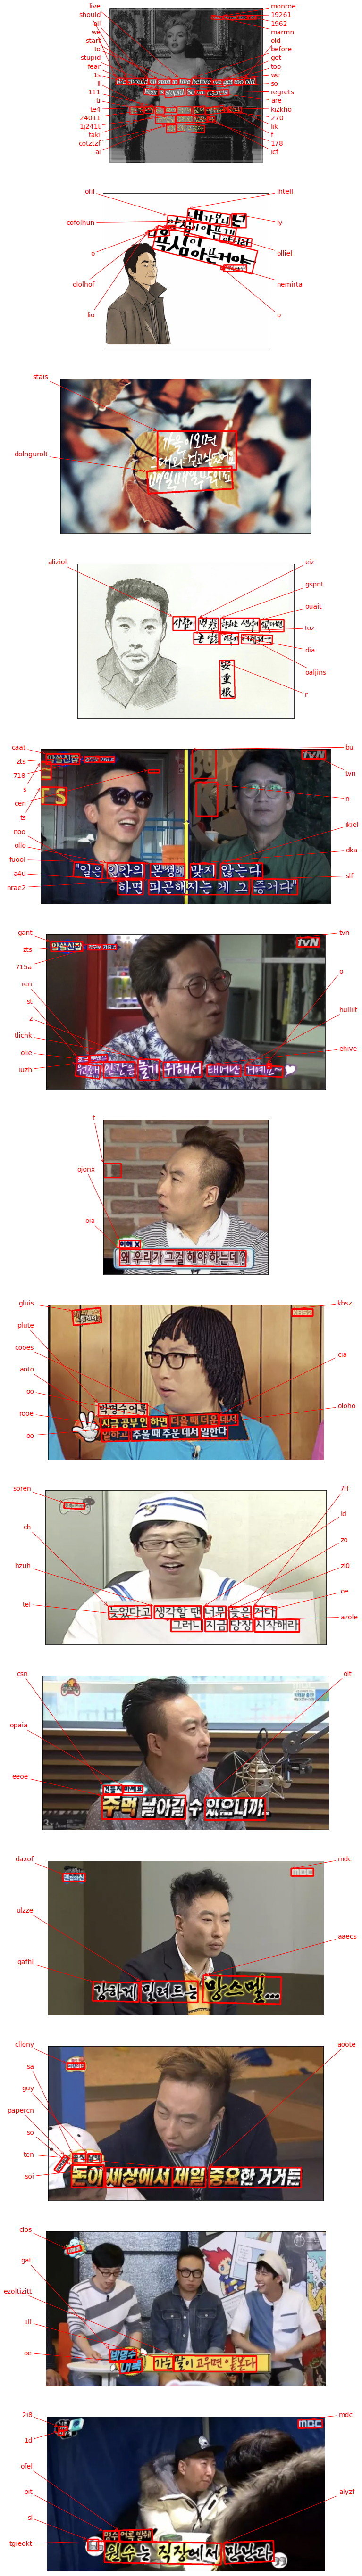

In [8]:
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# 테서랙트

In [16]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test'
img_file_path = work_dir + '/17.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 


cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/test/0000.png


In [17]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Done


## Step3. 테스트 결과 정리

## kears-ocr
### 한글을 인식하지 못해서 그런가? 한글이 가능했으면 지금처럼 인식하지 못하는 글자들을 인식할 수 있을지 궁금하다.

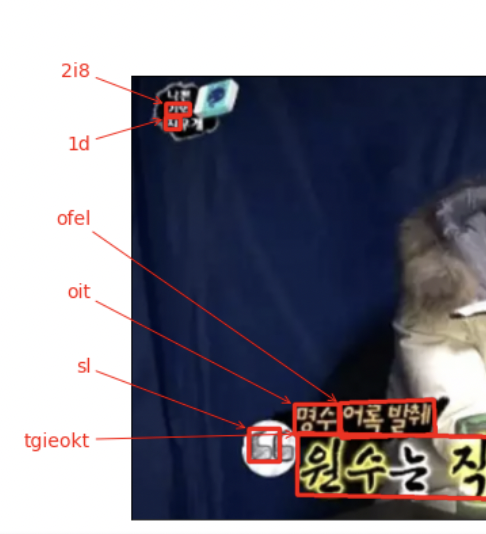
- 한글은 지원하지 않느다고 해도 " > 이거를 글자로 인식하고 , 왼쪽 상단에 글자를 몇개는 인식하지 못한다.

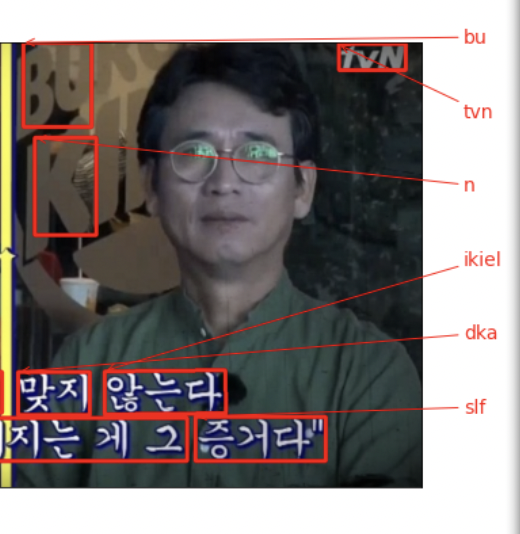
- 뒤에 있는 K 글자를 N으로 인식한다

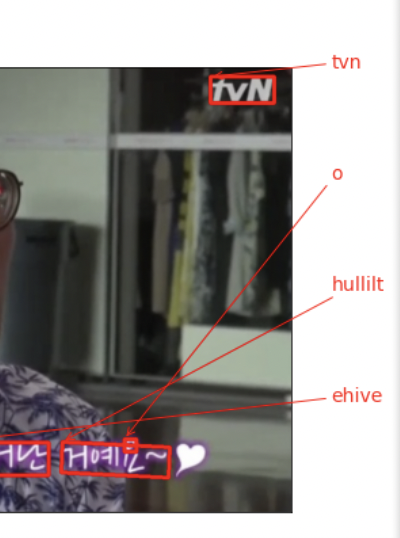
- 거에요 에서 ㅇ을 같은 글자로 인식하지 않고 따로 o으로 인식

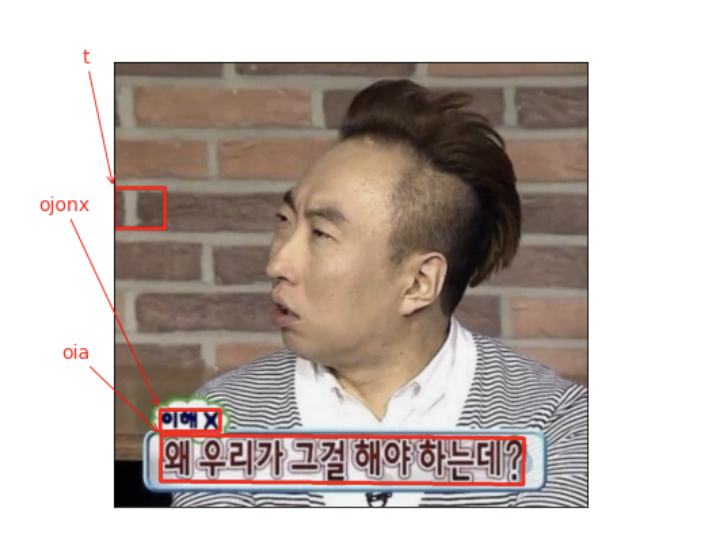
- 뒤에있는 벽돌틈 모양을 T로 인식

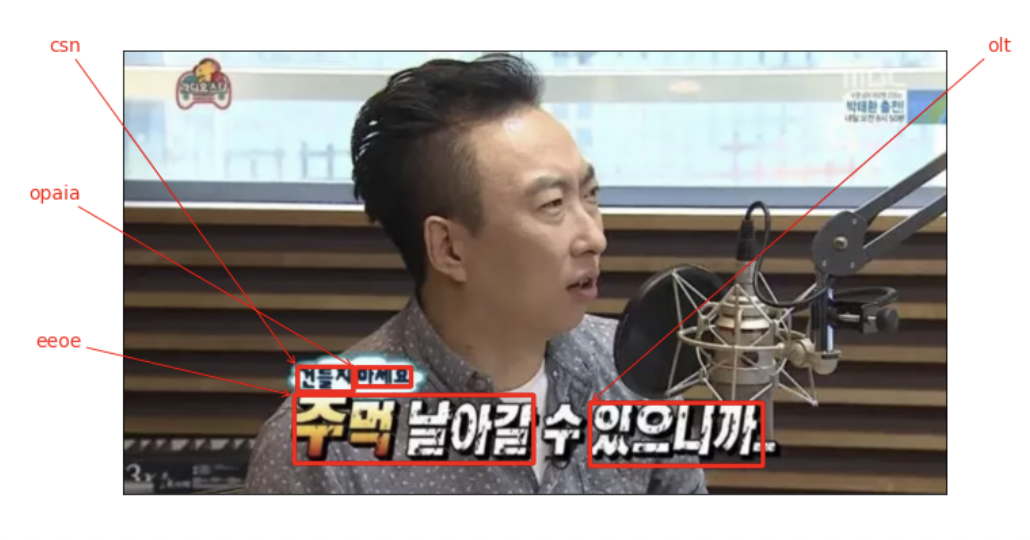
- 수를 인식하지 못하고 왼쪽, 오른쪽 상단에 있는 글자는 아예 인식하지 못한다.

## Step4. 결과 분석과 결론 제시

keras-ocr > 테서랙트 순으로 성능이 좋은거같다. 
keras-ocr은 한글은 인식하지 못해도 글자는 인식해서 출력하는 반면 테서랙트는 왜인지 어떤 글자도 출력하지 못한다?...


# 회고 
- keras-ocr은 한글 데이터셋으로 훈련되지 않은 모델인걸 모르고 한글 글귀만 모아놨는데 이게 무슨 날벼락 ㅜㅜ 
- 다시 돌리는데 keras-ocr 돌리는 중에 커널이 계속 죽는 현상이 발생한다 ;; 저번에 출력하고 캡쳐해 놓은 사진으로 결과를 정
